In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, LabelEncoder,  FunctionTransformer
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
import pickle
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
from preprocess_data import split_regions, categorize_bmi

In [81]:
file_path = 'data_cleaned.csv'

data = pd.read_csv(file_path)

X = data.drop('charges', axis=1)
y = data['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42, stratify=X['smoker'])
# 80% pour train et 20% de test


Recherche des meilleurs hyperparamètres de ElasticNet
Affichage du score, qui est le meilleur résultat

In [82]:
# Charger les données
data = pd.read_csv('data_cleaned.csv')
X = data.drop('charges', axis=1)
y = data['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42, stratify=X['smoker'])

# Création du pipeline principal
model_pipeline_linearRegression = make_pipeline(
    FunctionTransformer(split_regions),
    FunctionTransformer(categorize_bmi),
    ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), ['age', 'children']),
            ('cat', OneHotEncoder(), ['sex', 'smoker', 'bmi_category'])
        ]
    ),
    PolynomialFeatures(2),
    LinearRegression()
)

model_pipeline_lasso = make_pipeline(
    FunctionTransformer(split_regions),
    FunctionTransformer(categorize_bmi),
    ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), ['age', 'children']),
            ('cat', OneHotEncoder(), ['sex', 'smoker', 'bmi_category'])
        ]
    ),
    PolynomialFeatures(2),
    Lasso()
)

model_pipeline_ElasticNet = make_pipeline(
    FunctionTransformer(split_regions),
    FunctionTransformer(categorize_bmi),
    ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), ['age', 'children']),
            ('cat', OneHotEncoder(), ['sex', 'smoker', 'bmi_category'])
        ]
    ),
    PolynomialFeatures(2),
    ElasticNet()
)
param_grid = {
    'elasticnet__alpha': [0.0009000100000000001],#.arange(0.00000001, 0.001, 0.0001),
    'elasticnet__l1_ratio': [0.000001]#np.arange(0.00001, 0.2, 0.01)
}
model_grid_elasticNet = GridSearchCV(model_pipeline_ElasticNet, param_grid, cv=5)

# Entraînement et évaluation des modèle
model_pipeline_linearRegression.fit(X_train, y_train)
scoreLR = model_pipeline_linearRegression.score(X_test, y_test)
print(f"Score sur les données de test de LinearRegression: {scoreLR}")


model_pipeline_lasso.fit(X_train, y_train)
scoreLasso = model_pipeline_lasso.score(X_test, y_test)
print(f"Score sur les données de test de Lasso: {scoreLasso}")


model_grid_elasticNet.fit(X_train, y_train)
# print(model_grid_elasticNet.best_params_)
scoreElasticNet = model_grid_elasticNet.score(X_test, y_test)
print(f"Score sur les données de test de ElasticNet: {scoreElasticNet}")

bestModel = model_grid_elasticNet
bestScore = scoreElasticNet




Score sur les données de test de LinearRegression: 0.914064471448663
Score sur les données de test de Lasso: 0.9142273199376165
Score sur les données de test de ElasticNet: 0.9145342745197703


Export du model pour l'utiliser avec streamlit

In [83]:
# Sauvegarder le modèle dans un fichier .pkl
with open('exportModel.pkl', 'wb') as file:
    pickle.dump(bestModel, file)

with open('exportR2.pkl', 'wb') as file:
    pickle.dump(bestScore, file)

Ce code trace une courbe d'apprentissage pour notre modèle ElasticNet. Les zones ombragées autour des lignes représentent l'intervalle de confiance des scores. Si les courbes convergent et que les scores de validation augmentent avec plus de données, c'est un bon signe. En revanche, si les courbes restent éloignées l'une de l'autre, cela peut indiquer un overfitting.

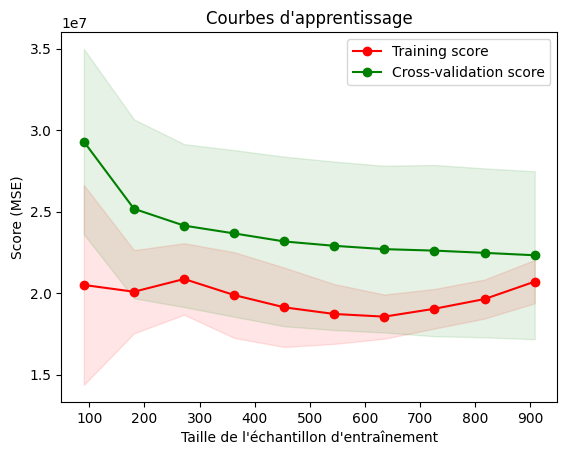

In [84]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# Définir les intervalles pour la taille de l'échantillon d'entraînement
train_sizes = np.linspace(0.1, 1.0, 10)

# Calculer les courbes d'apprentissage
train_sizes, train_scores, validation_scores = learning_curve(
    bestModel.best_estimator_, X_train, y_train, train_sizes=train_sizes, cv=5, scoring='neg_mean_squared_error'
)

# Calculer la moyenne et l'écart-type des scores d'entraînement et de validation
train_scores_mean = -train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
validation_scores_mean = -validation_scores.mean(axis=1)
validation_scores_std = validation_scores.std(axis=1)

# Tracer les courbes d'apprentissage
plt.figure()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title("Courbes d'apprentissage")
plt.xlabel("Taille de l'échantillon d'entraînement")
plt.ylabel("Score (MSE)")
plt.legend(loc="best")
plt.show()
